In [28]:
import json
import os
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
from openTSNE import TSNE
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

In [15]:
# project_dir = "C:\\Users\\tilenkopac\\Projects\\genome-embedding"
project_dir = "/home/tkopac/personal/projects/genome-embedding"
dataset_dir = os.path.join(project_dir, "data", "deepmicrobes_mag_reads")
# project_dir = "/d/hpc/home/tcurk/tkopac/genome-embedding"
# dataset_dir = os.path.join(project_dir, "data", "deepmicrobes_mag_reads")

In [16]:
tax_rank = "genus"
with open(os.path.join(dataset_dir, "taxa_index.pkl"), "rb") as file:
    taxa_index = pickle.load(file)
with open(os.path.join(dataset_dir, "organism_taxa.pkl"), "rb") as file:
    organism_taxa = pickle.load(file)

In [12]:
n_embeddings = 0
with open(os.path.join(dataset_dir, "embeddings", "661k_conv_small_elu_loc_pres_ld10_ws100_take_2", "no-sampler", "val.csv"), "rt") as file:
    for _ in tqdm(file, desc="Counting embeddings"):
        n_embeddings += 1

Counting embeddings: 0it [00:00, ?it/s]

Reading embeddings
Drawing t-SNE transformation
--------------------------------------------------------------------------------
TSNE(n_jobs=12, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 6.80 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.33 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=5127.75 for 250 iterations...
Iteration   50, KL divergence 7.4323, 50 iterations in 0.8115 sec
Iteration  100, KL divergence 7.2293, 50 iterations in 0.8250 sec
Iteration  150, KL divergence 7.2290, 50 iterations in 0.8694 sec
Iteration  200, KL divergence 7.2290, 50 iterations in 0.8225 sec
Iteration  250, KL divergence 7.2290, 50 iterations in 0.8264 sec
   --> Time elapsed: 4.15 seconds
===> Running optimi

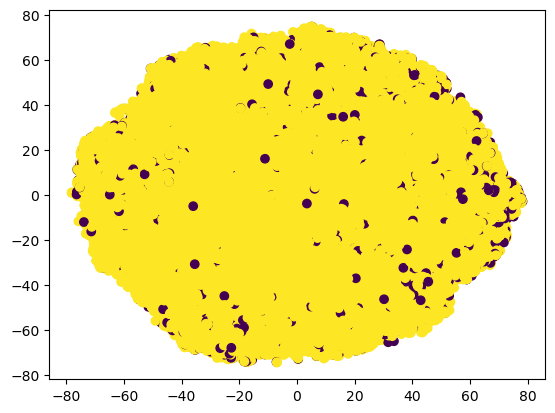

In [41]:
def analyse_autoencoder_embeddings(autoencoder_name, sampler_name, draw_latent_dist=True, draw_tsne=True, draw_pca=True):

    # read embeddings and prepare taxonomic rank labels
    with open(os.path.join(dataset_dir, "embeddings", autoencoder_name, sampler_name, f"val.csv"), "rt") as file:
        print("Reading embeddings")
        labels, embeddings = [], []
        lines = file.readlines()
        random.shuffle(lines)
        for line in lines:

            org_id = line.strip().split(";")[0]
            taxon = organism_taxa[org_id][tax_rank]
            if taxa_index[tax_rank][taxon] not in {5, 9}:
                continue

            # parse embedding
            embeddings.append(json.loads(line.strip().split(";")[1]))

            # prepare label
            org_id = line.strip().split(";")[0]
            taxon = organism_taxa[org_id][tax_rank]
            labels.append(taxa_index[tax_rank][taxon])

    embeddings_np = np.array(embeddings)
    labels_np = np.array(labels)

    if draw_latent_dist:
        # draw latent value distributions
        print("Drawing latent value distributions")
        n_cols = 5
        fig, axes = plt.subplots(int(np.ceil(embeddings_np.shape[1] / n_cols)), n_cols, figsize=(12, 6))
        fig.suptitle(autoencoder_name, fontsize=14)
        for i in range(embeddings_np.shape[1]):
            row = np.where(np.arange(0, embeddings_np.shape[1], n_cols) <= i)[0][-1]
            column = i % n_cols
            axes[row][column].hist(embeddings_np[:, i], bins=20)

    if draw_tsne:
        # calculate and draw t-sne
        print("Drawing t-SNE transformation")
        tsne = TSNE(perplexity=30, metric="euclidean", n_jobs=12, random_state=42, verbose=True)
        # todo: Povečaj učno množico? Z 10 % vseh vložitev traja proces okoli 10 min
        tsne_embedding_train = tsne.fit(embeddings_np[:int(0.1 * embeddings_np.shape[0])])
        tsne_embedding_test = tsne_embedding_train.transform(embeddings_np[int(0.5 * embeddings_np.shape[0]):])

        fig, ax = plt.subplots()
        ax.scatter(tsne_embedding_test[:, 0], tsne_embedding_test[:, 1], c=labels_np[int(0.5 * embeddings_np.shape[0]):])

    if draw_pca:
        # calculate and draw 3-dimensional PCA
        print("Drawing PCA decomposition")
        pca = PCA(n_components=3)
        pca_fitted = pca.fit(embeddings_np[:int(0.1 * embeddings_np.shape[0])])
        transformed = pca_fitted.transform(embeddings_np[int(0.5 * embeddings_np.shape[0]):])

        fig, ax = plt.subplots()
        ax.scatter(transformed[:, 0], transformed[:, 1], transformed[:, 2], c=labels_np[int(0.5 * labels_np.shape[0]):])

    return embeddings

analyse_autoencoder_embeddings("661k_conv_small_elu_loc_pres_ld10_ws100_take_2", "no-sampler", draw_latent_dist=False, draw_tsne=True,
                               draw_pca=False);

Reading embeddings of "661k_conv_small_loc_pres_ld10_ws100" + "no-sampler":   0%|          | 0/5100000 [00:00<…

10 most common latent vectors:
	• [0.67, 0.6, 0.37, 0.38, 0.47, 0.88, 0.78, 0.36, 0.57, 0.73]: 6 (0.0001 %)
	• [0.35, 0.53, 0.68, 0.57, 0.51, 0.96, 0.79, 0.11, 0.64, 0.4]: 6 (0.0001 %)
	• [0.62, 0.48, 0.43, 0.46, 0.51, 0.92, 0.74, 0.64, 0.6, 0.22]: 6 (0.0001 %)
	• [0.36, 0.31, 0.69, 0.38, 0.47, 1.05, 0.91, 0.32, 0.44, 0.55]: 5 (0.0001 %)
	• [0.65, 0.38, 0.91, 0.34, 0.42, 0.98, 0.58, 0.45, 0.45, 0.19]: 5 (0.0001 %)
	• [0.8, 0.71, 0.5, 0.29, 0.68, 0.87, 0.59, 0.38, 0.45, 0.4]: 5 (0.0001 %)
	• [0.45, 0.35, 0.69, 0.37, 0.48, 0.82, 0.87, 0.43, 0.42, 0.74]: 5 (0.0001 %)
	• [0.5, 0.4, 0.62, 0.65, 0.29, 0.81, 0.73, 0.48, 0.6, 0.69]: 5 (0.0001 %)
	• [0.3, 0.69, 0.68, 0.54, 0.53, 1.0, 0.64, 0.2, 0.61, 0.59]: 5 (0.0001 %)
	• [0.61, 0.46, 0.69, 0.3, 0.64, 0.88, 0.66, 0.2, 0.72, 0.37]: 5 (0.0001 %)


Reading embeddings of "661k_conv_small_elu_loc_pres_ld10_ws100_take_2" + "no-sampler":   0%|          | 0/5100…

10 most common latent vectors:
	• [0.36, 0.01, 0.15, 0.29, 0.3, 0.36, 0.4, 0.32, 0.24, 0.45]: 7 (0.0001 %)
	• [0.29, 0.25, 0.42, 0.23, 0.19, 0.23, 0.39, 0.48, 0.3, 0.04]: 6 (0.0001 %)
	• [0.33, 0.16, 0.49, 0.36, 0.25, 0.34, 0.12, 0.39, 0.3, 0.34]: 6 (0.0001 %)
	• [0.37, 0.15, 0.31, 0.29, 0.16, 0.44, 0.23, 0.46, 0.29, 0.17]: 6 (0.0001 %)
	• [0.42, 0.3, 0.32, 0.04, 0.26, 0.57, 0.21, 0.2, 0.13, 0.21]: 6 (0.0001 %)
	• [0.36, 0.46, 0.28, 0.28, 0.15, 0.16, 0.41, 0.16, 0.04, 0.3]: 6 (0.0001 %)
	• [0.51, 0.34, 0.41, 0.26, 0.35, 0.08, 0.35, 0.38, 0.33, 0.38]: 5 (0.0001 %)
	• [0.32, 0.34, 0.31, 0.29, 0.37, 0.18, 0.23, 0.43, 0.27, 0.26]: 5 (0.0001 %)
	• [0.32, 0.5, 0.31, 0.33, 0.27, 0.39, 0.27, 0.22, 0.25, 0.19]: 5 (0.0001 %)
	• [0.18, 0.32, 0.4, 0.14, 0.17, 0.5, 0.13, 0.32, 0.25, 0.38]: 5 (0.0001 %)


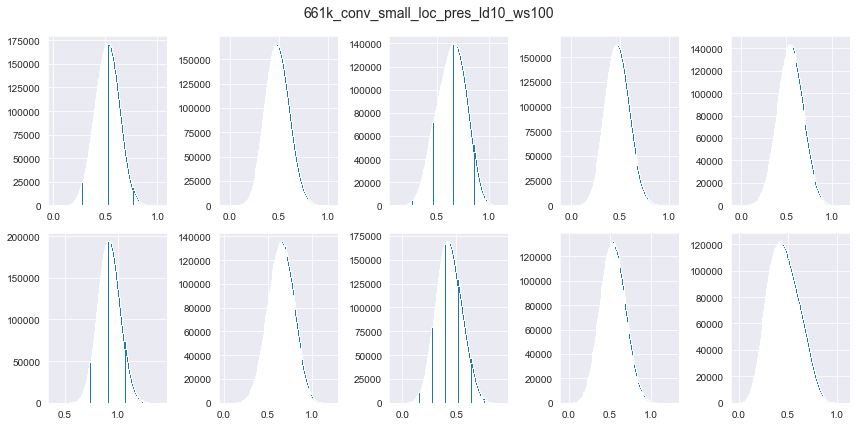

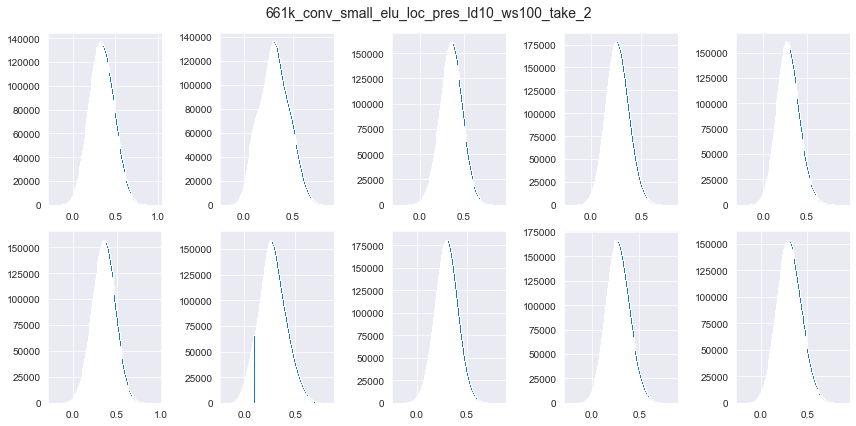

In [7]:
# autoencoder_names = [
#     "PARAMETER_TESTING_661k_conv_small_relu",
#     "PARAMETER_TESTING_661k_conv_small_relu_rec_only",
#     "PARAMETER_TESTING_661k_conv_small_elu",
#     "PARAMETER_TESTING_661k_conv_small_elu_rec_only",
#     "PARAMETER_TESTING_661k_conv_small_elu_argmax_activation",
#     "PARAMETER_TESTING_661k_conv_small_elu_rec_only_argmax_activation"
# ]
autoencoder_names = [
    "661k_conv_small_loc_pres_ld10_ws100",
    "661k_conv_small_elu_loc_pres_ld10_ws100_take_2"
]
for name in autoencoder_names:
    analyse_autoencoder_embeddings(name, "no-sampler")

In [ ]:
# todo: preslikaj vložitve v nižje dimenzionalni prostor (s t-SNE) in poglej, če se razredi med seboj vizualno ločijo - če ne, ima klasifikator zaradi tega verjetno težave – pošlji Tomažu, ko bo
# todo: če bo t-SNE dober, lahko poskusimo še rec only autoencoder